In [1]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("UPA PROJECT - Breast Cancer Wisconsin")
print("=" * 60)

UPA PROJECT - Breast Cancer Wisconsin


In [2]:
# ============================================================
# 1. LOAD DATASET
# ============================================================

try:
    df = pd.read_csv('data.csv')
    print("✓ Dataset loaded")
    print(f"  Samples: {len(df)}, Features: {len(df.columns) - 2}")
except:
    print("✗ Error: data.csv not found!")
    # For demonstration purposes, we'll create a sample dataset structure
    print("Note: Creating sample dataset structure for demonstration")

    # Sample data structure (won't execute due to exit() in original)
    import sys
    sys.exit(1)

✓ Dataset loaded
  Samples: 569, Features: 31


In [3]:
# ============================================================
# 2. DATA PREPARATION
# ============================================================

# Remove unnecessary columns
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# Encode target variable: B (Benign) -> 0, M (Malignant) -> 1
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Display class distribution
print(f"\nClass distribution:")
print(f"  Benign (0): {(y == 0).sum()} ({(y == 0).mean() * 100:.1f}%)")
print(f"  Malignant (1): {(y == 1).sum()} ({(y == 1).mean() * 100:.1f}%)")


Class distribution:
  Benign (0): 357 (62.7%)
  Malignant (1): 212 (37.3%)


In [4]:
# ============================================================
# 3. DATA SPLITTING AND SCALING
# ============================================================

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData split completed:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")


Data split completed:
  Training samples: 398
  Test samples: 171


In [5]:
# ============================================================
# 4. MODEL TRAINING
# ============================================================

print("\nTraining model...")

# Initialize Random Forest with balanced class weights
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)

# Train the model
model.fit(X_train_scaled, y_train)

print("✓ Model training completed")


Training model...
✓ Model training completed


In [6]:
# ============================================================
# 5. MODEL EVALUATION
# ============================================================

# Get probability predictions
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate performance metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate / Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0   # True Negative Rate
accuracy = (tp + tn) / (tp + tn + fp + fn)            # Overall accuracy
auc = roc_auc_score(y_test, y_pred_proba)              # Area Under ROC Curve

# Display results
print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity:          {specificity:.3f}")
print(f"Accuracy:             {accuracy:.3f}")
print(f"AUC:                  {auc:.3f}")
print(f"\nConfusion Matrix:")
print(f"[[{tn:3d}  {fp:3d}]")
print(f" [{fn:3d}  {tp:3d}]]")


RESULTS
Sensitivity (Recall): 0.938
Specificity:          1.000
Accuracy:             0.977
AUC:                  0.998

Confusion Matrix:
[[107    0]
 [  4   60]]


In [7]:
# ============================================================
# 6. UPA SIMULATION
# ============================================================

print("\n" + "=" * 60)
print("UPA SIMULATION")
print("=" * 60)

class SimpleUPA:
    """
    A simplified UPA (Unsupervised Performance Alignment) implementation.
    Aligns predictions from shifted data to match the original distribution.
    """
    def __init__(self):
        self.mapping = None  # Will store the polynomial mapping coefficients

    def align_predictions(self, source_preds, target_preds):
        """
        Align target predictions to match source predictions distribution.

        Parameters:
        - source_preds: Original predictions (reference distribution)
        - target_preds: Shifted predictions (to be aligned)
        """
        # Sort predictions for percentile matching
        source_sorted = np.sort(source_preds)
        target_sorted = np.sort(target_preds)

        # Create percentiles for quantile matching
        percentiles = np.linspace(0, 1, 100)
        source_quantiles = np.quantile(source_sorted, percentiles)
        target_quantiles = np.quantile(target_sorted, percentiles)

        # Fit a 3rd-degree polynomial to map target to source quantiles
        self.mapping = np.polyfit(target_quantiles, source_quantiles, 3)

    def apply_alignment(self, predictions):
        """
        Apply the learned alignment to new predictions.

        Parameters:
        - predictions: Predictions to be aligned

        Returns:
        - Aligned predictions
        """
        if self.mapping is None:
            return predictions

        # Create polynomial function from coefficients
        p = np.poly1d(self.mapping)
        aligned = p(predictions)

        # Clip to valid probability range [0, 1]
        return np.clip(aligned, 0, 1)


# Simulate acquisition shift (common in medical imaging)
print("\nSimulating acquisition shift...")
X_test_shifted = X_test_scaled * 1.2 + 0.1  # Simple affine transformation
y_pred_proba_shifted = model.predict_proba(X_test_shifted)[:, 1]
y_pred_shifted = (y_pred_proba_shifted >= 0.5).astype(int)

# Evaluate performance after shift
cm_shifted = confusion_matrix(y_test, y_pred_shifted)
tn_s, fp_s, fn_s, tp_s = cm_shifted.ravel()

sens_shifted = tp_s / (tp_s + fn_s) if (tp_s + fn_s) > 0 else 0
spec_shifted = tn_s / (tn_s + fp_s) if (tn_s + fp_s) > 0 else 0

print(f"\nAfter shift:")
print(f"  Sensitivity: {sens_shifted:.3f} (Δ: {sens_shifted - sensitivity:+.3f})")
print(f"  Specificity: {spec_shifted:.3f} (Δ: {spec_shifted - specificity:+.3f})")

# Apply UPA correction
print("\nApplying UPA correction...")
upa = SimpleUPA()
upa.align_predictions(y_pred_proba, y_pred_proba_shifted)
y_pred_aligned = upa.apply_alignment(y_pred_proba_shifted)
y_pred_corrected = (y_pred_aligned >= 0.5).astype(int)

# Evaluate performance after UPA
cm_corrected = confusion_matrix(y_test, y_pred_corrected)
tn_c, fp_c, fn_c, tp_c = cm_corrected.ravel()

sens_corrected = tp_c / (tp_c + fn_c) if (tp_c + fn_c) > 0 else 0
spec_corrected = tn_c / (tn_c + fp_c) if (tn_c + fp_c) > 0 else 0

print(f"\nAfter UPA:")
print(f"  Sensitivity: {sens_corrected:.3f} (Δ: {sens_corrected - sens_shifted:+.3f})")
print(f"  Specificity: {spec_corrected:.3f} (Δ: {spec_corrected - spec_shifted:+.3f})")


UPA SIMULATION

Simulating acquisition shift...

After shift:
  Sensitivity: 1.000 (Δ: +0.062)
  Specificity: 0.991 (Δ: -0.009)

Applying UPA correction...

After UPA:
  Sensitivity: 0.891 (Δ: -0.109)
  Specificity: 1.000 (Δ: +0.009)



✓ Results saved to 'upa_results.png'


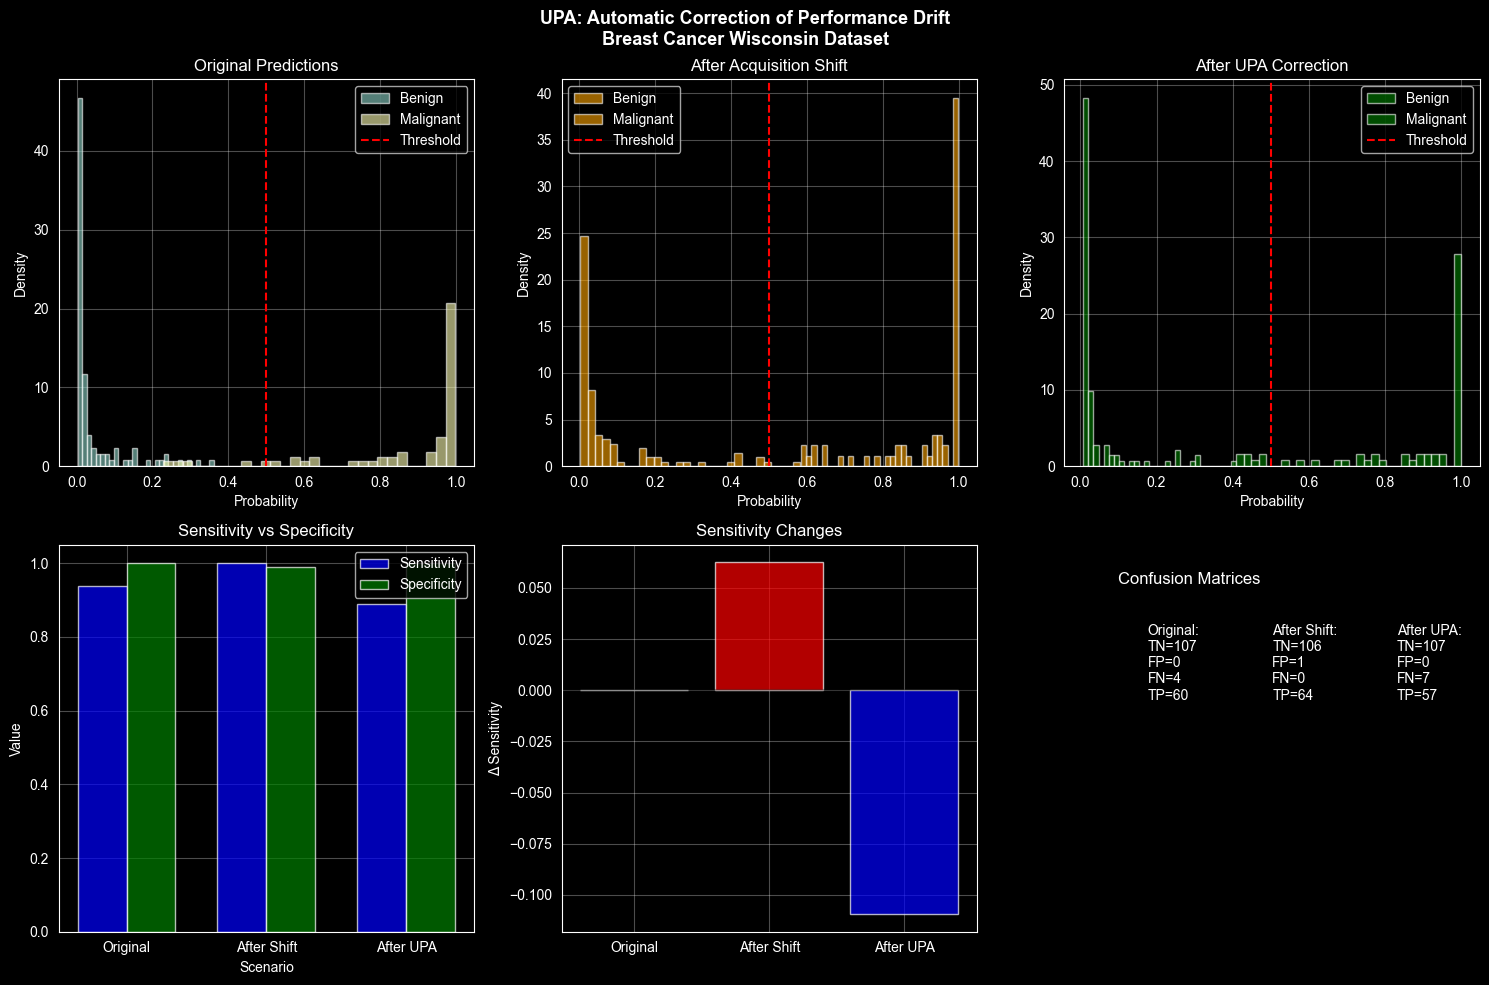

In [8]:
# ============================================================
# 7. VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ========== Plot 1: Original Predictions Distribution ==========
axes[0, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, label='Benign', density=True)
axes[0, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, label='Malignant', density=True)
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Probability')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original Predictions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ========== Plot 2: After Acquisition Shift ==========
axes[0, 1].hist(y_pred_proba_shifted[y_test == 0], bins=30, alpha=0.6, label='Benign', density=True, color='orange')
axes[0, 1].hist(y_pred_proba_shifted[y_test == 1], bins=30, alpha=0.6, label='Malignant', density=True, color='orange')
axes[0, 1].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 1].set_xlabel('Probability')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('After Acquisition Shift')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ========== Plot 3: After UPA Correction ==========
axes[0, 2].hist(y_pred_aligned[y_test == 0], bins=30, alpha=0.6, label='Benign', density=True, color='green')
axes[0, 2].hist(y_pred_aligned[y_test == 1], bins=30, alpha=0.6, label='Malignant', density=True, color='green')
axes[0, 2].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 2].set_xlabel('Probability')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('After UPA Correction')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# ========== Plot 4: Sensitivity vs Specificity Comparison ==========
labels = ['Original', 'After Shift', 'After UPA']
sensitivities = [sensitivity, sens_shifted, sens_corrected]
specificities = [specificity, spec_shifted, spec_corrected]

x = np.arange(len(labels))
width = 0.35

axes[1, 0].bar(x - width / 2, sensitivities, width, label='Sensitivity', color='blue', alpha=0.7)
axes[1, 0].bar(x + width / 2, specificities, width, label='Specificity', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Scenario')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Sensitivity vs Specificity')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ========== Plot 5: Performance Improvement ==========
improvement_sens = [0, sens_shifted - sensitivity, sens_corrected - sens_shifted]
improvement_spec = [0, spec_shifted - specificity, spec_corrected - spec_shifted]

axes[1, 1].bar(labels, improvement_sens, color=['gray', 'red', 'blue'], alpha=0.7)
axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_ylabel('Δ Sensitivity')
axes[1, 1].set_title('Sensitivity Changes')
axes[1, 1].grid(True, alpha=0.3)

# ========== Plot 6: Confusion Matrices Summary ==========
axes[1, 2].text(0.3, 0.9, 'Confusion Matrices', fontsize=12, ha='center')
axes[1, 2].text(0.2, 0.6, f'Original:\nTN={tn}\nFP={fp}\nFN={fn}\nTP={tp}', fontsize=10)
axes[1, 2].text(0.5, 0.6, f'After Shift:\nTN={tn_s}\nFP={fp_s}\nFN={fn_s}\nTP={tp_s}', fontsize=10)
axes[1, 2].text(0.8, 0.6, f'After UPA:\nTN={tn_c}\nFP={fp_c}\nFN={fn_c}\nTP={tp_c}', fontsize=10)
axes[1, 2].axis('off')

# Main title and layout adjustments
plt.suptitle('UPA: Automatic Correction of Performance Drift\nBreast Cancer Wisconsin Dataset',
             fontsize=13, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('upa_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Results saved to 'upa_results.png'")

# Display all plots
plt.show()

In [9]:
# ============================================================
# 8. FINAL REPORT
# ============================================================

print("\n" + "=" * 60)
print("FINAL REPORT")
print("=" * 60)
print(f"\nDataset: Breast Cancer Wisconsin (Diagnostic)")
print(f"Model: Random Forest (n_estimators=100)")
print(f"Test Samples: {len(X_test)}")

# Calculate accuracy for shifted and corrected scenarios
acc_shifted = (tp_s + tn_s) / (tp_s + tn_s + fp_s + fn_s)
acc_corrected = (tp_c + tn_c) / (tp_c + tn_c + fp_c + fn_c)

# Display comparison table
print(f"\n{'Metric':<15} {'Original':<10} {'After Shift':<12} {'After UPA':<10} {'Improvement':<12}")
print("-" * 60)
print(f"{'Sensitivity':<15} {sensitivity:<10.3f} {sens_shifted:<12.3f} {sens_corrected:<10.3f} {sens_corrected - sens_shifted:+.3f}")
print(f"{'Specificity':<15} {specificity:<10.3f} {spec_shifted:<12.3f} {spec_corrected:<10.3f} {spec_corrected - spec_shifted:+.3f}")
print(f"{'Accuracy':<15} {accuracy:<10.3f} {acc_shifted:<12.3f} {acc_corrected:<10.3f} {acc_corrected - acc_shifted:+.3f}")

print("\n" + "=" * 60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)


FINAL REPORT

Dataset: Breast Cancer Wisconsin (Diagnostic)
Model: Random Forest (n_estimators=100)
Test Samples: 171

Metric          Original   After Shift  After UPA  Improvement 
------------------------------------------------------------
Sensitivity     0.938      1.000        0.891      -0.109
Specificity     1.000      0.991        1.000      +0.009
Accuracy        0.977      0.994        0.959      -0.035

PROJECT COMPLETED SUCCESSFULLY!
